# Image Classification using Convolution Neural Network
The main task is to build a classifier, that can help us to sort the
scans into three categories like healthy patients, pre-existing conditions, and Serious condition who needs immediate attention.

In [3]:
#Importing Necessary Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Data Exploration

In [4]:
#Uploading the files to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Loading the Necessary Files
image_data=np.load('/content/drive/MyDrive/Colab Data/ps4_trainvalid_images.npy')
label_data=pd.read_csv('/content/drive/MyDrive/Colab Data/ps4_trainvalid_labels.csv')

In [6]:
#Shape of the Image Dataset
print("Shape of the Image Dataset=",image_data.shape)

Shape of the Image Dataset= (13260, 64, 64, 1)


In [7]:
#Shape of the Label
print("Shape of the Label Dataset=",label_data.shape)
label_data["Label"].value_counts()

Shape of the Label Dataset= (13260, 2)


0    10506
1     2372
2      382
Name: Label, dtype: int64

In [8]:
#Checking Which Id is in Class-0,1 and 2 alternatively just for Visualization Purpose
c0 = []              
for i in label_data['Id']:
    if label_data['Label'][i] == 0:
        c0.append(i)
#print("Id of Class 0:",c0)


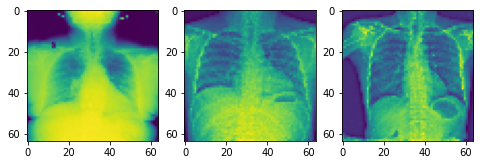

In [9]:
#X-Ray Visualization
from keras.preprocessing.image import array_to_img
i0 = array_to_img(image_data[0])
i1 = array_to_img(image_data[7])
i2 = array_to_img(image_data[27])

#Plotting the images from dataset
fig, axes = plt.subplots(1, 3, figsize = (8, 4))
axes[0].imshow(i0)
axes[1].imshow(i1)
axes[2].imshow(i2)
plt.show()

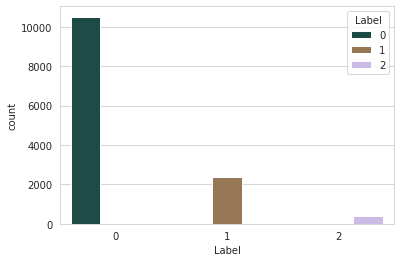

In [10]:
#Plotting the Count Plot to visualize the number of Label Classes
import seaborn as sns
sns.set_style('whitegrid')
sns.countplot(x='Label',hue='Label',data=label_data,palette='cubehelix')

In [11]:
#Original Count of Labels
from collections import Counter
labels = Counter(label_data["Label"])
print(labels)

Counter({0: 10506, 1: 2372, 2: 382})


#Data Augmentation
After Exploring the dataset, we knew that the class labels are highly imbalanced. To deal with such problems, I need to construct more balanced data using Data Augmentation technique to increase the count of minority label classes.

In [12]:
#Taking only the "Label"Columns from Label Dataset
label_data=label_data["Label"]

In [13]:
#Data Augmentation
# List of Id of label 1
lab_1 = []              
for i in range(len(label_data)):
    if label_data[i] == 1:
        lab_1.append(i)
len(lab_1)

2372

In [14]:
# Data Augmentation for Label 1
from keras.preprocessing.image import ImageDataGenerator
aug_label1 = []

#Here I tried creating various number of images from 1 original image
for i in range(0,8):
    datagenerator = ImageDataGenerator(     
                                       width_shift_range=0.1, 
                                       height_shift_range=0.2, 
                                       horizontal_flip = True, 
                                       vertical_flip=True,
                                       brightness_range = [0.8, 1.6])
    datagenerator.fit(image_data[lab_1])
    for data in datagenerator.flow(image_data[lab_1], batch_size = 1000):
        break
    for k in data:
        aug_label1.append(k)
aug_label1 = np.array(aug_label1)

In [15]:
# List of Id of label 2
lab_2 = []              
for i in range(len(label_data)):
    if label_data[i] == 2:
        lab_2.append(i)
len(lab_2)

382

In [16]:
# Data Augmentation for Label 1
aug_label2 = []

#Here I tried creating various number of images from 1 original image
for i in range(0,27):
    datagenerator = ImageDataGenerator(     
                                       
                                       width_shift_range=0.1, 
                                       height_shift_range=0.2, 
                                       horizontal_flip = True, 
                                       vertical_flip=True,
                                       brightness_range = [0.8, 1.6])
    datagenerator.fit(image_data[lab_2])
    for data in datagenerator.flow(image_data[lab_2], batch_size = 3500):
        break
    for k in data:
        aug_label2.append(k)
aug_label2 = np.array(aug_label2)

In [17]:
#Appending the augmented data and labels for label1 and label2 into actual dataset
image_data = np.append(image_data,aug_label1,axis = 0)
image_data = np.append(image_data,aug_label2,axis = 0)
label_data = label_data.tolist()
for i in range(len(aug_label1)):
    label_data.append(1)
for j in range(len(aug_label2)):
    label_data.append(2)
label_data = pd.Series(label_data)

In [18]:
#Shape of Updated Image Data
image_data.shape

(31574, 64, 64, 1)

In [19]:
#Shape of Updated Label Data
label_data.shape

(31574,)

In [20]:
#Counter of Labels
from collections import Counter
labels = Counter(label_data)
print(labels)

Counter({2: 10696, 0: 10506, 1: 10372})


In [21]:
#Transforming a class vector (integers) to binary class matrix.
from tensorflow.keras.utils import to_categorical
label_data = to_categorical(label_data)

In [22]:
#Performing Test-Train-Valid Split in the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_data, label_data, test_size = 0.2,shuffle=True, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20,shuffle=True, random_state=42)

# Model Selection
 For Model Selection, I built 4 architectures of CNN Model using the architecture of LeNet-5, VGGNet, AlexNet with various Conv2D layers followed by MaxPooling2D layers and fitted them with different epochs and batch size. Moreover, I also built a custom architecture with comparatively less complex structure than pre-existing models.

In [23]:
pip install tensorflow-addons

     |████████████████████████████████| 706kB 10.8MB/s 


In [24]:
#Importing Necessary Libraries for training CNN
import keras
import keras.utils
from sklearn.metrics import f1_score
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense, Activation, Dropout
from keras.regularizers import l1
import tensorflow_addons as tfa
from keras.models import load_model

# leNet5 Architecture
Using the Architecture of LeNet5, I created 2 Conv2D layers with relu activation and Padding followed by MaxPooling Layer and 2 Dense Layers at end. Moreover, I also tried Kernel and Dense Layer Absolute Weight Regularizer L1 with Bias Regularizer to avoid bias in classification tasks.

In [25]:
#Training Convolutional Neural Network(LeNet5) from scratch
model=Sequential()
model.add(Conv2D(filters=20,kernel_size=(3,3),padding="same",activation="relu",input_shape=(64,64,1)))
model.add(MaxPooling2D(pool_size=(2,2),strides=None, padding="same"))

model.add(Conv2D(filters=50,kernel_size=(3,3),padding="same",activation ="relu"))
#model.add(Dropout(0.20))
model.add(MaxPooling2D(pool_size=(2,2),strides=None, padding="same"))

model.add(Flatten(input_shape=(64,64,1)))
model.add(Dense(512,activation="relu"))
model.add(Dense(3,activation="softmax"))

#Model Summary of LeNet 5 Architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 20)        200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 50)        9050      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 50)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               6554112   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [26]:
#Model Compilation (With Matrics including Macro and Micro F1 Score and AUC Score)
opt = Adam(lr=0.0001)
model.compile(optimizer=opt,
               loss=tf.losses.CategoricalCrossentropy(from_logits=False),
               metrics=["AUC","accuracy",
                        tf.metrics.AUC(multi_label=True,name='auc_multi',label_weights=[0.1,0.4,0.6]),
                        tfa.metrics.F1Score(num_classes=3, average='macro', name="F1_macro"),
                        tfa.metrics.F1Score(num_classes=3, average='micro', name="F1_micro"),
               ])

In [27]:
#Fitting the Model
lenet=model.fit(X_train, y_train,
               callbacks=[EarlyStopping(monitor='val_loss', mode='min' , verbose =1, patience = 2)],
          validation_data=(X_val,y_val), batch_size=100,
          epochs=30)

Epoch 1/30
203/203 [==============================] - 38s 35ms/step - loss: 17.6466 - auc: 0.6482 - accuracy: 0.4882 - auc_multi: 0.6069 - F1_macro: 0.4879 - F1_micro: 0.4882 - val_loss: 2.6052 - val_auc: 0.7199 - val_accuracy: 0.5578 - val_auc_multi: 0.7240 - val_F1_macro: 0.4784 - val_F1_micro: 0.5578
Epoch 2/30
203/203 [==============================] - 6s 30ms/step - loss: 1.7064 - auc: 0.7903 - accuracy: 0.6189 - auc_multi: 0.7243 - F1_macro: 0.6188 - F1_micro: 0.6189 - val_loss: 3.0815 - val_auc: 0.6312 - val_accuracy: 0.4070 - val_auc_multi: 0.6443 - val_F1_macro: 0.3268 - val_F1_micro: 0.4070
Epoch 3/30
203/203 [==============================] - 6s 30ms/step - loss: 1.1192 - auc: 0.8412 - accuracy: 0.6663 - auc_multi: 0.7792 - F1_macro: 0.6665 - F1_micro: 0.6663 - val_loss: 0.8406 - val_auc: 0.8431 - val_accuracy: 0.6490 - val_auc_multi: 0.7818 - val_F1_macro: 0.6602 - val_F1_micro: 0.6490
Epoch 4/30
203/203 [==============================] - 6s 30ms/step - loss: 0.8672 - auc: 

#VGGNet Architecture
Using the Architecture of VGGNet, I created 5 Conv2D layers with relu activation and Padding followed by 3 MaxPooling Layer and 2 Dense Layers at end.Moreover, I also tried Kernel and Dense Layer Absolute Weight Regularizer L1 with Bias Regularizer to avoid bias in classification tasks.

In [28]:
#Training Convolutional Neural Network from scratch (VGG)

model2=Sequential()
model2.add(Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",input_shape=(64,64,1)))
model2.add(MaxPooling2D(pool_size=(2,2),strides=None, padding="same"))

model2.add(Conv2D(filters=64,kernel_size=(3,3),padding="same",activation ="relu"))
model2.add(Conv2D(filters=64,kernel_size=(3,3),padding="same",activation ="relu"))
model2.add(MaxPooling2D(pool_size=(2,2),strides=None, padding="same"))
#model2.add(Dropout(0.20))

model2.add(Conv2D(filters=128,kernel_size=(3,3),padding="same",activation="relu"))
model2.add(Conv2D(filters=128,kernel_size=(3,3),padding="same",activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2),strides=None, padding="same"))

#model2.add(Dropout(0.20))
model2.add(Flatten())
model2.add(Dense(512,activation="relu"))
#model2.add(Dense(64,activation="relu"))
model2.add(Dense(3,activation="softmax"))

#Model Summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)      

In [29]:
#Model Compilation (With Matrics including Macro and Micro F1 Score and AUC Score)
opt = Adam(lr=0.0001)
model2.compile(optimizer=opt,
               loss=tf.losses.CategoricalCrossentropy(from_logits=False),
               metrics=["AUC","accuracy",
                        tf.metrics.AUC(multi_label=True,name='auc_multi',label_weights=[0.1,0.4,0.6]),
                        tfa.metrics.F1Score(num_classes=3, average='macro', name="F1_macro"),
                        tfa.metrics.F1Score(num_classes=3, average='micro', name="F1_micro"),
               ])

In [30]:
#Fitting the Model
vgg= model2.fit( X_train, y_train, 
          validation_data=(X_val,y_val), 
          callbacks=[EarlyStopping(monitor='val_loss', mode='min' , verbose =1, patience = 2)], 
          epochs=50
          )

Epoch 1/50
632/632 [==============================] - 20s 29ms/step - loss: 1.6291 - auc: 0.7610 - accuracy: 0.5724 - auc_multi: 0.7074 - F1_macro: 0.5673 - F1_micro: 0.5724 - val_loss: 0.6694 - val_auc: 0.8652 - val_accuracy: 0.6572 - val_auc_multi: 0.8164 - val_F1_macro: 0.6363 - val_F1_micro: 0.6572
Epoch 2/50
632/632 [==============================] - 17s 27ms/step - loss: 0.5695 - auc: 0.8981 - accuracy: 0.7169 - auc_multi: 0.8363 - F1_macro: 0.7133 - F1_micro: 0.7169 - val_loss: 0.5402 - val_auc: 0.9049 - val_accuracy: 0.7235 - val_auc_multi: 0.8420 - val_F1_macro: 0.7171 - val_F1_micro: 0.7235
Epoch 3/50
632/632 [==============================] - 17s 27ms/step - loss: 0.5163 - auc: 0.9175 - accuracy: 0.7500 - auc_multi: 0.8647 - F1_macro: 0.7491 - F1_micro: 0.7500 - val_loss: 0.5093 - val_auc: 0.9181 - val_accuracy: 0.7484 - val_auc_multi: 0.8659 - val_F1_macro: 0.7481 - val_F1_micro: 0.7484
Epoch 4/50
632/632 [==============================] - 17s 27ms/step - loss: 0.4675 - auc

# AlexNet Architecture
Using the Architecture of AlexNet with Normalization, I created 5 Conv2D layers with relu activation and Padding followed by 2 MaxPooling Layer and 2 Dense Layers at end.Moreover, I also tried using Kernel and Dense Layer Absolute Weight Regularizer L1 with Bias Regularizer to avoid bias in classification tasks.

In [31]:
#Training Convolutional Neural Network from scratch (AlexNet)

model3 =Sequential()
model3.add(layers.experimental.preprocessing.Resizing(128, 128, interpolation="bilinear", input_shape=(64,64,1)))
model3.add(layers.Conv2D(32,kernel_size=(3,3),strides=4, padding='same'))
model3.add(layers.Lambda(tf.nn.local_response_normalization))
model3.add(layers.Activation('relu'))

model3.add(layers.MaxPooling2D(2, strides=2))
model3.add(layers.Conv2D(32,kernel_size=(3,3),strides=4, padding='same'))

model3.add(layers.Lambda(tf.nn.local_response_normalization))
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D(2, strides=2))
#model3.add(layers.Dropout(0.2))

model3.add(layers.Conv2D(64,kernel_size=(3,3),strides=4, padding='same'))
model3.add(layers.Activation('relu'))

model3.add(layers.Conv2D(64,kernel_size=(3,3),strides=4, padding='same'))
model3.add(layers.Activation('relu'))

model3.add(layers.Conv2D(128,kernel_size=(3,3),strides=4, padding='same'))
model3.add(layers.Activation('relu'))
model3.add(layers.Flatten())

model3.add(layers.Dense(512, activation='relu'))
#model3.add(layers.Dropout(0.2))

model3.add(layers.Dense(1028, activation='relu'))
model3.add(layers.Dense(3, activation='softmax'))
#Model Summary of AlexNet Architecture
#model3.summary()

In [32]:
#Model Compilation (With Matrics including Macro and Micro F1 Score and AUC Score)
opt = Adam(lr=0.0001)
model3.compile(optimizer=opt,
               loss=tf.losses.CategoricalCrossentropy(from_logits=False),
               metrics=["AUC","accuracy",
                        tf.metrics.AUC(multi_label=True,name='auc_multi',label_weights=[0.1,0.4,0.6]),
                        tfa.metrics.F1Score(num_classes=3, average='macro', name="F1_macro"),
                        tfa.metrics.F1Score(num_classes=3, average='micro', name="F1_micro"),
               ])

In [33]:
#Fitting AlexNet Model
alex= model3.fit(X_train, y_train, 
          validation_data=(X_val,y_val), 
          callbacks=[EarlyStopping(monitor='val_loss', mode='min' , verbose =1, patience = 2)], 
          epochs=30,batch_size=100
          )

Epoch 1/30
203/203 [==============================] - 9s 38ms/step - loss: 1.0823 - auc: 0.5605 - accuracy: 0.3725 - auc_multi: 0.5467 - F1_macro: 0.2400 - F1_micro: 0.3725 - val_loss: 0.8303 - val_auc: 0.7898 - val_accuracy: 0.5629 - val_auc_multi: 0.7277 - val_F1_macro: 0.5591 - val_F1_micro: 0.5629
Epoch 2/30
203/203 [==============================] - 7s 34ms/step - loss: 0.8001 - auc: 0.8041 - accuracy: 0.5791 - auc_multi: 0.7395 - F1_macro: 0.5599 - F1_micro: 0.5791 - val_loss: 0.7552 - val_auc: 0.8204 - val_accuracy: 0.5940 - val_auc_multi: 0.7523 - val_F1_macro: 0.5804 - val_F1_micro: 0.5940
Epoch 3/30
203/203 [==============================] - 7s 35ms/step - loss: 0.7421 - auc: 0.8254 - accuracy: 0.5977 - auc_multi: 0.7539 - F1_macro: 0.5867 - F1_micro: 0.5977 - val_loss: 0.7206 - val_auc: 0.8336 - val_accuracy: 0.6114 - val_auc_multi: 0.7626 - val_F1_macro: 0.5924 - val_F1_micro: 0.6114
Epoch 4/30
203/203 [==============================] - 7s 35ms/step - loss: 0.7077 - auc: 0.

# Custom CNN Architecture
In this Architecture, I used 2 Convolutional Layers with Relu Activation followed by 1 MaxPool layer and at the end I used 2 Dense Layers.

In [34]:
#Custom CNN Architecture
model4 =Sequential()
model4.add(layers.Conv2D(128, (3, 3), activation = 'relu', input_shape = (64,64,1)))
model4.add(layers.MaxPooling2D(2, 2))


model4.add(layers.Conv2D(256, (3, 3), activation = 'relu'))
model4.add(layers.MaxPooling2D(2, 2))

model4.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model4.add(layers.MaxPooling2D(2, 2))

model4.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model4.add(layers.Flatten(input_shape = (64,64,1)))

model4.add(layers.Dense(32, activation = 'relu'))
model4.add(layers.Dense(16, activation = 'relu'))
model4.add(layers.Dense(3, activation = 'softmax'))

#Summary Of Model
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 128)       1280      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 29, 29, 256)       295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 128)       295040    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 64)         

In [35]:
#Model Compilation (With Matrics including Macro and Micro F1 Score and AUC Score)
opt = Adam(lr=0.0005)
model4.compile(optimizer=opt,
               loss=tf.losses.CategoricalCrossentropy(from_logits=False),
               metrics=["AUC","accuracy",
                        tf.metrics.AUC(multi_label=True,name='auc_multi',label_weights=[0.1,0.4,0.6]),
                        tfa.metrics.F1Score(num_classes=3, average='macro', name="F1_macro"),
                        tfa.metrics.F1Score(num_classes=3, average='micro', name="F1_micro"),
               ])

In [37]:
#Fitting the custom model
custom= model4.fit(X_train, y_train, validation_data=(X_val,y_val),
          callbacks=[EarlyStopping(monitor='val_loss', mode='min' , verbose =1, patience = 2)], 
          epochs=30)

Epoch 1/30
632/632 [==============================] - 26s 41ms/step - loss: 0.6553 - auc: 0.8597 - accuracy: 0.6460 - auc_multi: 0.7799 - F1_macro: 0.6328 - F1_micro: 0.6460 - val_loss: 0.6079 - val_auc: 0.8748 - val_accuracy: 0.6669 - val_auc_multi: 0.7963 - val_F1_macro: 0.6409 - val_F1_micro: 0.6669
Epoch 2/30
632/632 [==============================] - 24s 39ms/step - loss: 0.6024 - auc: 0.8791 - accuracy: 0.6762 - auc_multi: 0.8015 - F1_macro: 0.6641 - F1_micro: 0.6762 - val_loss: 0.6498 - val_auc: 0.8676 - val_accuracy: 0.6637 - val_auc_multi: 0.7990 - val_F1_macro: 0.6249 - val_F1_micro: 0.6637
Epoch 3/30
632/632 [==============================] - 24s 39ms/step - loss: 0.5673 - auc: 0.8906 - accuracy: 0.6911 - auc_multi: 0.8144 - F1_macro: 0.6818 - F1_micro: 0.6911 - val_loss: 0.5579 - val_auc: 0.8956 - val_accuracy: 0.7035 - val_auc_multi: 0.8261 - val_F1_macro: 0.7020 - val_F1_micro: 0.7035
Epoch 4/30
632/632 [==============================] - 24s 39ms/step - loss: 0.5534 - auc

# Model Evaluation: Validation and Loss Graphs
The CNN Model are evaluated using Training & Validation Loss and Accuracy Graphs and Confusion Matrix

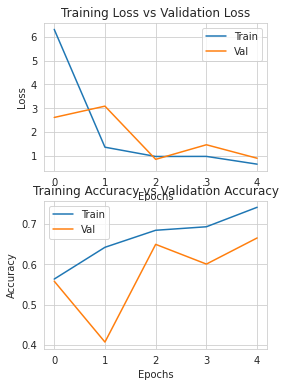

In [38]:
#Plotting Traning and Validation Loss,Accuracy of LeNet Architecture
#Loss
fig, axs = plt.subplots(2, 1, figsize=(4,6))
axs[0].plot(lenet.history['loss'])
axs[0].plot(lenet.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])

#Accuracy
axs[1].plot(lenet.history['accuracy'])
axs[1].plot(lenet.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

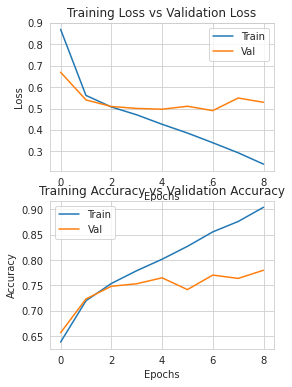

In [39]:
#Plotting Traning and Validation Loss,Accuracy of VGG Architecture
#Loss
fig, axs = plt.subplots(2, 1, figsize=(4,6))
axs[0].plot(vgg.history['loss'])
axs[0].plot(vgg.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])

#Accuracy
axs[1].plot(vgg.history['accuracy'])
axs[1].plot(vgg.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

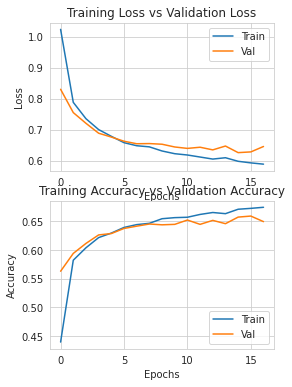

In [40]:
#Plotting Traning and Validation Loss,Accuracy of AlexNet Architecture
#Loss
fig, axs = plt.subplots(2, 1, figsize=(4,6))
axs[0].plot(alex.history['loss'])
axs[0].plot(alex.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])

#Accuracy
axs[1].plot(alex.history['accuracy'])
axs[1].plot(alex.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

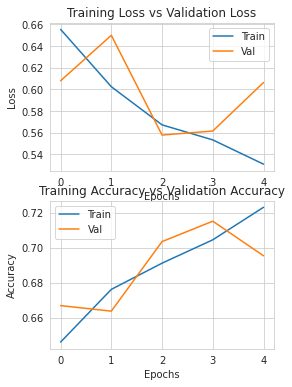

In [41]:
#Plotting Traning and Validation Loss,Accuracy of custom Architecture
#Loss
fig, axs = plt.subplots(2, 1, figsize=(4,6))
axs[0].plot(custom.history['loss'])
axs[0].plot(custom.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])

#Accuracy
axs[1].plot(custom.history['accuracy'])
axs[1].plot(custom.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

# Confusion Matrix, AUC Score, F1 Macro 
Using Confusion matrix, I calculated effective matrix such as F1 Macro, Accuracy and AUC Score on Test Data. 


**LeNet-5 Model Score**

In [42]:
#Prediction for LeNet-5 Model:
lenet_pred = model.predict_classes(X_test, batch_size=128, verbose=0)
lenet_pred[7]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0

In [43]:
#Converting Matrix Labels data to Single Digit
sin_labels=np.argmax(y_test, axis=1)
sin_labels[13]

0

In [44]:
#Confusion Matrix for LeNet-5 Model:
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(sin_labels, lenet_pred)
cm1

array([[1955,  193,   11],
       [ 103, 1654,  323],
       [  43, 1427,  606]])

In [45]:
# Calculating F1-score for LeNet-5 CNN Model
print("F1-score of LeNet-5 Model:",f1_score(sin_labels,lenet_pred, average='macro'))

F1-score of LeNet-5 Model: 0.6458509827512373


In [47]:
# Calculating AUC Score for LeNet-5 CNN Model
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_auc_score
print("AUC Score of LeNet-5  Model:",roc_auc_score(sin_labels,model.predict_proba(X_test),multi_class='ovr'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


AUC Score of LeNet-5  Model: 0.8572201371736329


**VGGNet Model Score**

In [48]:
#Prediction for VGGNet Model:
vgg_pred = model2.predict_classes(X_test, batch_size=128, verbose=0)
vgg_pred[7]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0

In [49]:
#Confusion Matrix for VGGNet Model:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(sin_labels, vgg_pred)
cm2

array([[2085,   70,    4],
       [ 122, 1352,  606],
       [  28,  574, 1474]])

In [50]:
# Calculating F1-score for VGGNet CNN Model
print("F1-score of VGGNet Model:",f1_score(sin_labels,vgg_pred, average='macro'))

F1-score of VGGNet Model: 0.7736902415775281


In [51]:
# Calculating AUC Score for VGGNet CNN Model
print("AUC Score of VGGNet  Model:",roc_auc_score(sin_labels,model2.predict_proba(X_test),multi_class='ovr'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


AUC Score of VGGNet  Model: 0.9119678275542618


**AlexNet Model Score**

In [52]:
#Prediction for AlexNet Model:
alex_pred = model3.predict_classes(X_test, batch_size=128, verbose=0)
alex_pred[7]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0

In [53]:
#Confusion Matrix for AlexNet Model:
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(sin_labels, alex_pred)
cm3

array([[2099,   57,    3],
       [ 348,  553, 1179],
       [ 128,  472, 1476]])

In [54]:
# Calculating F1-score for AlexNet CNN Model
print("F1-score of AlexNet Model:",f1_score(sin_labels,alex_pred, average='macro'))

F1-score of AlexNet Model: 0.6200430919877388


In [55]:
# Calculating AUC Score for AlexNet CNN Model
print("AUC Score of AlexNet  Model:",roc_auc_score(sin_labels,model3.predict_proba(X_test),multi_class='ovr'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


AUC Score of AlexNet  Model: 0.8360203494012474


**Custom Model Score**

In [56]:
#Prediction for Custom Model:
custom_pred = model4.predict_classes(X_test, batch_size=128, verbose=0)
custom_pred[7]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0

In [57]:
#Confusion Matrix for Custom Model:
from sklearn.metrics import confusion_matrix
cm4 = confusion_matrix(sin_labels, custom_pred)
cm4

array([[1856,  256,   47],
       [  63,  827, 1190],
       [  17,  344, 1715]])

In [58]:
# Calculating F1-score for Custom CNN Model
print("F1-score of Custom Model:",f1_score(sin_labels,custom_pred, average='macro'))

F1-score of Custom Model: 0.6867597572855315


In [59]:
# Calculating AUC Score for Custom CNN Model
print("AUC Score of Custom  Model:",roc_auc_score(sin_labels,model4.predict_proba(X_test),multi_class='ovr'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


AUC Score of Custom  Model: 0.871115548245681


# Confusion Matrix Accuracy
I calculated Accuracy using Confusion Matrix to evaluate the performance.For accuracy, I divided sum of diagonal element by sum of all elements.

In [61]:
#Function Calculate Accuracy
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 
print("Accuracy of Model:",accuracy(cm2))

Accuracy of Model: 0.7776722090261282


# Kaggle Challenge

In [ ]:
#Loading Kaggle Dataset
kaggle=np.load('/content/drive/MyDrive/Colab Data/ps4_kaggle_images.npy')
kaggle.shape

In [ ]:
#Predicting the Classification of Kaggle Dataset and converting it into Dataframe
kag_label = model2.predict_classes(kaggle)
kag_predict = pd.DataFrame()
kag_predict["Predicted"]=kag_label

In [ ]:
kag_predict

In [ ]:
#Converting to CSV Format
#kag_predict.to_csv("tryy.csv")

In [ ]:
#from google.colab import files
#files.download("tryy.csv")